In [2]:
import pandas as pd
import seaborn as sns
from warnings import filterwarnings
filterwarnings('ignore')

# sns.set(font_scale=5.5)
sns.set(style="darkgrid")
sns.set(rc={'figure.figsize':(11.7,8.27)}, font_scale=1.5)
df_hrv = pd.read_csv("../data/original/HeartRateVariabilitySDNN.csv")

def parse_date(x):
    return pd.datetime.strptime(x[:-6],'%Y-%m-%d %H:%M:%S')

series = pd.read_csv('../data/original/HeartRateVariabilitySDNN.csv', header=0, index_col=5, parse_dates=[5], squeeze=True, date_parser=parse_date)

df = pd.DataFrame()
df['value'] = series['value']
df['creationDate'] = pd.to_datetime(df.index)
df = df.reset_index(drop=True)

df.describe()


,value
count,932.000000
mean,41.249294
std,15.685212
min,8.212030
25%,30.839050
50%,38.808450
75%,49.548450
max,173.526000


,date,HRV (SDNN),Is at Work (binary),Is Above Mean Value,Hour of Day,Day of Week,Is Morning
0,2018-01-16 09:50:18,32.3970,1,0,9,2,1
1,2018-01-16 09:55:05,45.1124,1,1,9,2,1
2,2018-01-16 14:52:15,27.3781,1,0,14,2,0
3,2018-01-16 21:24:11,41.4216,0,1,21,2,0
4,2018-01-18 09:08:50,41.0526,1,0,9,4,1


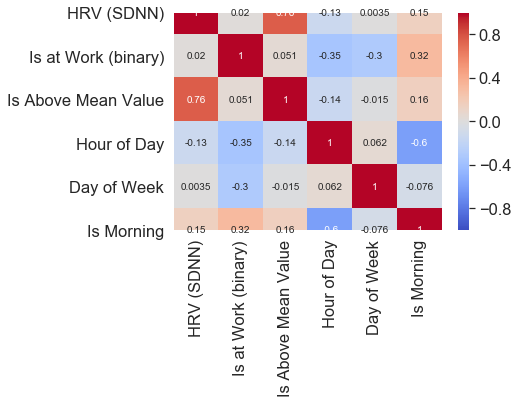

In [3]:
hrv_merged = pd.DataFrame()

def at_work(row):
    hour = row['creationDate'].hour
    weekday = row['creationDate'].isoweekday()
    
    if((hour >= 9 and hour <17) and weekday < 6):
        # print(pd.to_datetime(row['creationDate']), (weekday))
        return 1
    return 0
    
# winter is from 1st of November to 1st of April
def is_winter(row):
    month = pd.to_datetime(row['creationDate'], format='%d/%m').month
    
    if(month >= 10 or month < 4):
        return 1
    return 0

def is_higher_than_mean(row):
    mean = 41.25
    if row.value > mean:
        return 1
    return 0

def get_hour_of_day(row):
    hour = pd.to_datetime(row['creationDate']).hour
    return hour

def get_day_of_week(row):
    weekday = pd.to_datetime(row['creationDate']).isoweekday()
    return weekday

def get_time_of_day(row):
    hour = pd.to_datetime(row['creationDate']).hour
    
    if((hour >= 6 and hour <12)):
        return 1
    return 0
    
    
hrv_merged['date'] = df['creationDate']
hrv_merged['HRV (SDNN)'] = df['value']

work_hours = []
winter_time = []
above_mean = []
hour_of_day = []
day_of_week = []
time_of_day = [] # is morning or afternoon



for (index, row) in df.iterrows():   
    work_hours.append(at_work(row))
#     winter_time.append(is_winter(row))
    above_mean.append(is_higher_than_mean(row))
    hour_of_day.append(get_hour_of_day(row))
    day_of_week.append(get_day_of_week(row))
    time_of_day.append(get_time_of_day(row))
    if (row['value'] > 150):
        df.drop(index, inplace=True)
    
hrv_merged['Is at Work (binary)'] = work_hours
hrv_merged['Is Above Mean Value'] = above_mean
hrv_merged['Hour of Day'] = hour_of_day
hrv_merged['Day of Week'] = day_of_week
hrv_merged['Is Morning'] = time_of_day


hrv_merged.to_csv('../data/hrv_shaped.csv')

sns.heatmap(hrv_merged.corr(),
            vmin=-1,
            cmap='coolwarm',
            annot=True);

hrv_merged.head()

In [4]:
hrv_merged.describe()

,HRV (SDNN),Is at Work (binary),Is Above Mean Value,Hour of Day,Day of Week,Is Morning
count,932.000000,932.000000,932.000000,932.000000,932.000000,932.000000
mean,41.249294,0.431330,0.433476,14.000000,3.629828,0.297210
std,15.685212,0.495528,0.495821,5.308931,1.836289,0.457275
min,8.212030,0.000000,0.000000,0.000000,1.000000,0.000000
25%,30.839050,0.000000,0.000000,10.000000,2.000000,0.000000
50%,38.808450,0.000000,0.000000,14.000000,4.000000,0.000000
75%,49.548450,1.000000,1.000000,18.000000,5.000000,1.000000
max,173.526000,1.000000,1.000000,23.000000,7.000000,1.000000


|       |   HRV (SDNN) |   Day of Week |
|:------|-------------:|--------------:|
| count |    932       |     932       |
| mean  |     41.2493  |       3.62983 |
| std   |     15.6852  |       1.83629 |
| min   |      8.21203 |       1       |
| 25%   |     30.8391  |       2       |
| 50%   |     38.8085  |       4       |
| 75%   |     49.5485  |       5       |
| max   |    173.526   |       7       |


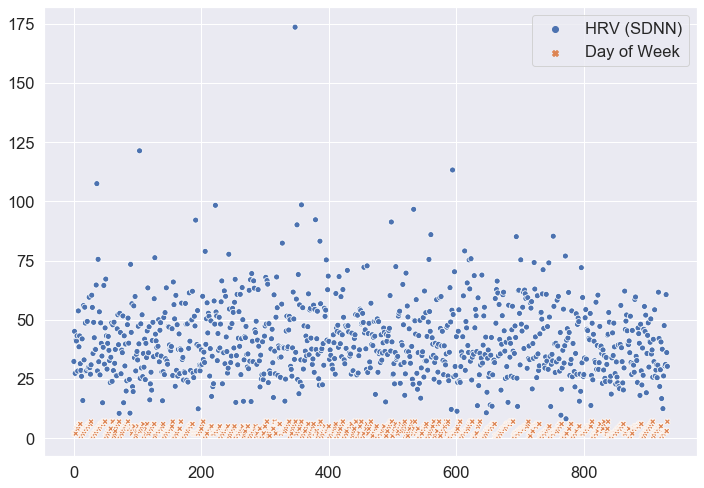

In [50]:
from tabulate import tabulate
sns.set(rc={'figure.figsize':(11.7,8.27)}, font_scale=1.5)

# X = hrv_merged['HRV (SDNN)'].values.reshape(-1,1)
# data = hrv_merged.iloc[:, 1:4]

data = []

X = hrv_merged[['HRV (SDNN)', 'Day of Week']]

sx = sns.scatterplot(data=X)

X.describe()

df_cluster = hrv_merged[['HRV (SDNN)', 'Day of Week']]

# df_cluster.head()

print(tabulate(df_cluster.describe(), tablefmt="pipe", headers="keys"))

fig = sx.get_figure()
fig.savefig("../report/images/unsupervised_clustering_1.png")

## Agglomerated Hierarquical Clustering

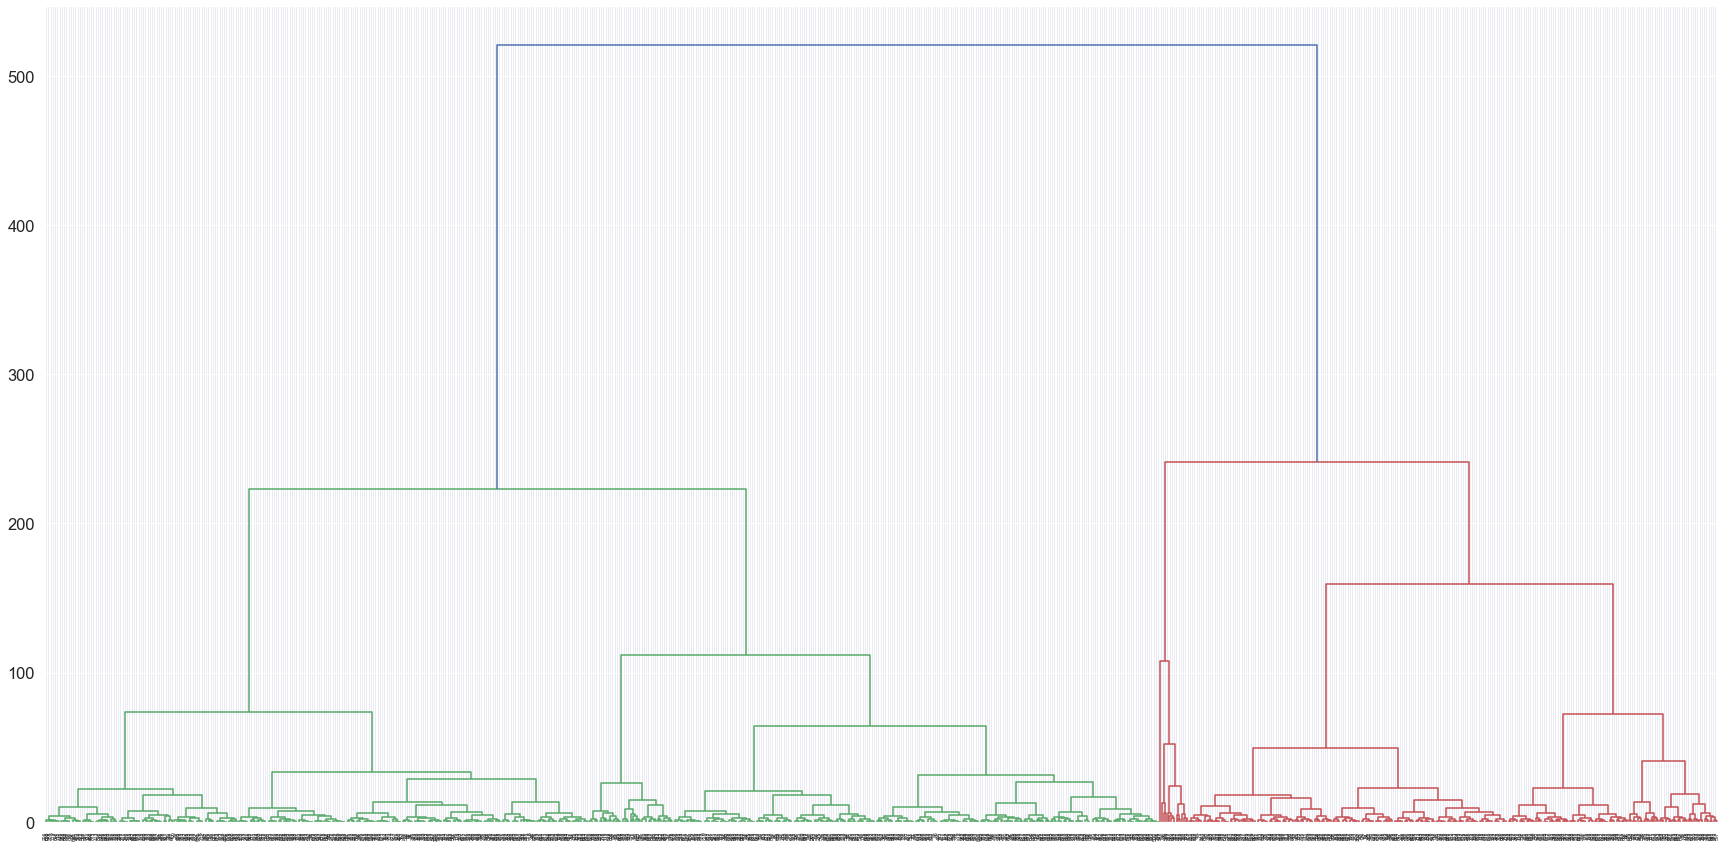

In [24]:
import scipy.cluster.hierarchy as shc
import matplotlib.pyplot as plt

plt.figure(figsize=(30, 15))
# plt.title("Customer Dendograms")
dend = shc.dendrogram(shc.linkage(X, method='ward'))

# fig = dend.get_figure()
plt.savefig("../report/images/unsupervised_clustering_dend.png")



In [41]:
from sklearn.cluster import AgglomerativeClustering

model = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')
model.fit(X)
labels = model.labels_

print(labels.shape)
print(X.shape)
# plt.scatter(X[labels==0, 0], X[labels==0, 1], s=50, marker='o', color='red')
# plt.scatter(X[labels==1, 0], X[labels==1, 1], s=50, marker='o', color='blue')
# plt.scatter(X[labels==2, 0], X[labels==2, 1], s=50, marker='o', color='green')
# plt.scatter(X[labels==3, 0], X[labels==3, 1], s=50, marker='o', color='purple')
# plt.scatter(X[labels==4, 0], X[labels==4, 1], s=50, marker='o', color='orange')
# plt.show()

(932,)
(932, 2)


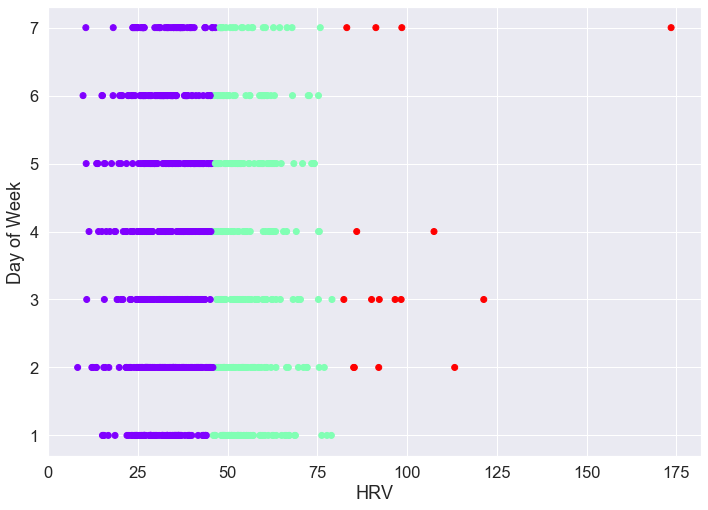

In [49]:
# print(X['HRV (SDNN)'].values)

plt.scatter(X['HRV (SDNN)'].values, X['Day of Week'].values, c=labels, cmap='rainbow')


plt.xlabel('HRV')
plt.ylabel('Day of Week')
plt.savefig("../report/images/unsupervised_clustering_agglomerative.png")

## Gaussian mixture model

In [89]:
from sklearn import model_selection
from sklearn.mixture import GaussianMixture

X = hrv_merged[['HRV (SDNN)', 'Day of Week']].values

CV = model_selection.KFold(n_splits=10,shuffle=True)
KRange = range(1,2)
covar_type = 'full' 
reps = 10
init_procedure = 'kmeans'
i = 0

score = []
fold = []

for t,K in enumerate(KRange):
        print('Fitting model for K={0}'.format(K))
        

        # Fit Gaussian mixture model
#         gmm = GaussianMixture(n_components=K, covariance_type=covar_type, 
#                               n_init=reps, init_params=init_procedure,
#                               tol=1e-6, reg_covar=1e-6).fit(X)
        
        # Get BIC and AIC
#         BIC[t,] = gmm.bic(X)
#         AIC[t,] = gmm.aic(X)

        # For each crossvalidation fold
        for train_index, test_index in CV.split(X):
            i+=1
            print(i)
            fold.append(i)
            # extract training and test set for current CV fold
            X_train = X[train_index]
            X_test = X[test_index]

            # Fit Gaussian mixture model to X_train
            gmm = GaussianMixture(n_components=i, covariance_type=covar_type, n_init=reps).fit(X_train)
            print(-gmm.score(X_test))
            score.append(-gmm.score(X_test))
    
            
            # compute negative log likelihood of X_test
#             CVE[t] += -gmm.score_samples(X_test).sum()

Fitting model for K=1
1
6.297808175493016
2
6.300364933423362
3
5.852024559106882
4
6.157139247462511
5
6.491369864814354
6
5.984310185900112
7
6.085042310261233
8
6.053119743174751
9
6.12831375927225
10
6.0883472981494995


In [90]:
df_gmm = pd.DataFrame()

df_gmm['Score (average log-likelihood)'] = score
df_gmm['Fold'] = fold

print(tabulate(df_gmm.head(10), tablefmt="pipe", headers="keys"))

|    |   Score (average log-likelihood) |   Fold |
|---:|---------------------------------:|-------:|
|  0 |                          6.29781 |      1 |
|  1 |                          6.30036 |      2 |
|  2 |                          5.85202 |      3 |
|  3 |                          6.15714 |      4 |
|  4 |                          6.49137 |      5 |
|  5 |                          5.98431 |      6 |
|  6 |                          6.08504 |      7 |
|  7 |                          6.05312 |      8 |
|  8 |                          6.12831 |      9 |
|  9 |                          6.08835 |     10 |


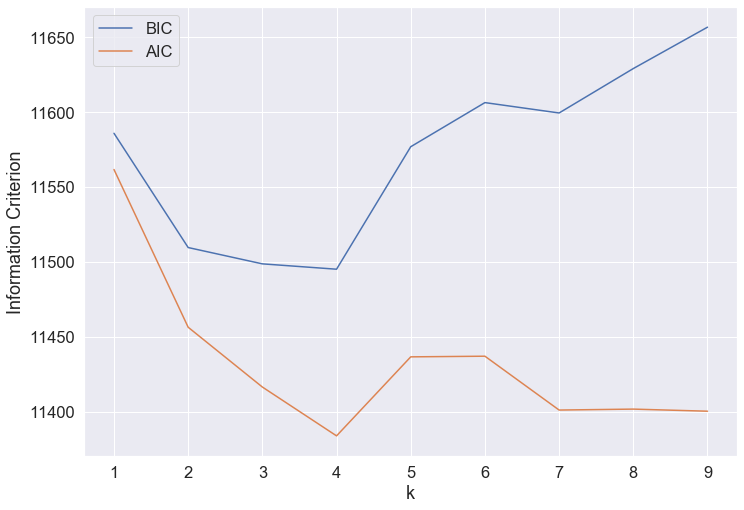

In [107]:
import numpy as np
n_components = np.arange(1, 10)
models = [GaussianMixture(n, covariance_type='full', n_init=reps).fit(X) for n in n_components]

plt.plot(n_components, [m.bic(X) for m in models], label='BIC')
plt.plot(n_components, [m.aic(X) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('k');
plt.ylabel('Information Criterion')

plt.savefig("../report/images/gmm_elbow.png")

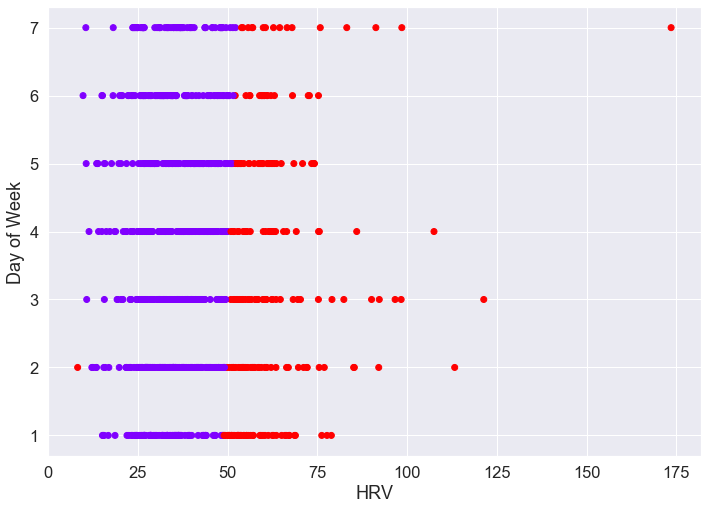

In [108]:
gmm = GaussianMixture(n_components=2)
gmm.fit(X)

labels = gmm.predict(X)

# print(X[:,0])
plt.xlabel('HRV')
plt.ylabel('Day of Week')
plt.scatter(X[:,0], X[:,1], c=labels, cmap='rainbow');
plt.savefig('../report/images/gmm_clusters.png')

Fitting model for K=1
Fitting model for K=2
Fitting model for K=3
Fitting model for K=4
Fitting model for K=5
Fitting model for K=6
Fitting model for K=7
Fitting model for K=8
Fitting model for K=9
Fitting model for K=10


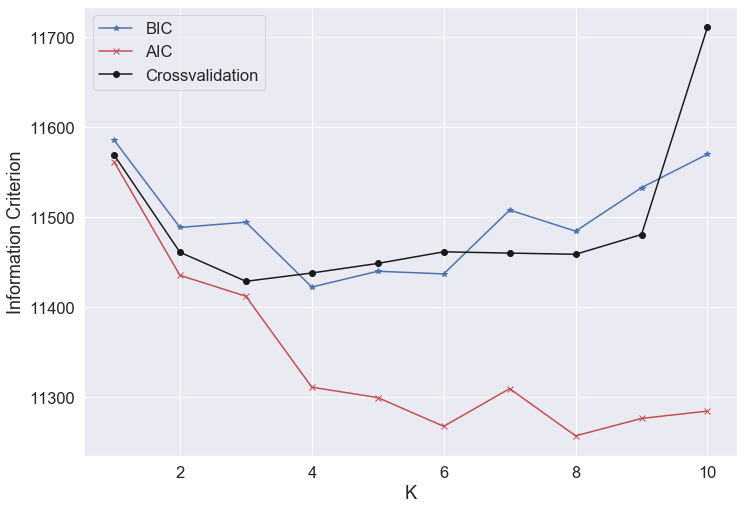

<Figure size 842.4x595.44 with 0 Axes>

In [105]:
# exercise 11.1.5
from matplotlib.pyplot import figure, plot, legend, xlabel, show
import numpy as np
from scipy.io import loadmat
from sklearn.mixture import GaussianMixture
from sklearn import model_selection

# Load Matlab data file and extract variables of interest
# attributeNames = [name[0] for name in mat_data['attributeNames'].squeeze()]
# classNames = [name[0][0] for name in mat_data['classNames']]
# N, M = X.shape
# C = len(classNames)


# Range of K's to try
KRange = range(1,11)
T = len(KRange)

covar_type = 'full'       # you can try out 'diag' as well
reps = 3                  # number of fits with different initalizations, best result will be kept
init_procedure = 'kmeans' # 'kmeans' or 'random'

# Allocate variables
BIC = np.zeros((T,))
AIC = np.zeros((T,))
CVE = np.zeros((T,))

# K-fold crossvalidation
CV = model_selection.KFold(n_splits=10,shuffle=True)

for t,K in enumerate(KRange):
        print('Fitting model for K={0}'.format(K))

        # Fit Gaussian mixture model
        gmm = GaussianMixture(n_components=K, covariance_type=covar_type, 
                              n_init=reps, init_params=init_procedure,
                              tol=1e-6, reg_covar=1e-6).fit(X)
        
        # Get BIC and AIC
        BIC[t,] = gmm.bic(X)
        AIC[t,] = gmm.aic(X)

        # For each crossvalidation fold
        for train_index, test_index in CV.split(X):

            # extract training and test set for current CV fold
            X_train = X[train_index]
            X_test = X[test_index]

            # Fit Gaussian mixture model to X_train
            gmm = GaussianMixture(n_components=K, covariance_type=covar_type, n_init=reps).fit(X_train)

            # compute negative log likelihood of X_test
            CVE[t] += -gmm.score_samples(X_test).sum()
            

# Plot results

figure(1); 
plot(KRange, BIC,'-*b')
plot(KRange, AIC,'-xr')
plot(KRange, 2*CVE,'-ok')
plt.xlabel('k');
plt.ylabel('Information Criterion')
legend(['BIC', 'AIC', 'Crossvalidation'])
xlabel('K')
show()

# plt.savefig('../report/images/gmm_aicbiccv.png')

## Anomaly detection

In [241]:
# from scipy import stats

# kernel = stats.gaussian_kde(X)

# kernel.covariance


In [110]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

hrv_copy = hrv_merged.dropna().set_index('date')

hrv_scaled = scaler.fit_transform(hrv_copy)

df_hrv_scaled = pd.DataFrame(hrv_scaled)
df_hrv_scaled.columns = ['HRV', 'At Work', 'Above Mean', 'Hour of day', 'Day of week', 'Is morning']
# hrv_copy.head()
# df_hrv_scaled.corr() // It's the same as non-scaled values

df_hrv_scaled.head()

X = df_hrv_scaled['HRV'].values.reshape(-1,1)

# df_hrv_scaled.describe()

hrv_copy.head()


,HRV (SDNN),Is at Work (binary),Is Above Mean Value,Hour of Day,Day of Week,Is Morning
date,,,,,,
2018-01-16 09:50:18,32.3970,1,0,9,2,1
2018-01-16 09:55:05,45.1124,1,1,9,2,1
2018-01-16 14:52:15,27.3781,1,0,14,2,0
2018-01-16 21:24:11,41.4216,0,1,21,2,0
2018-01-18 09:08:50,41.0526,1,0,9,4,1


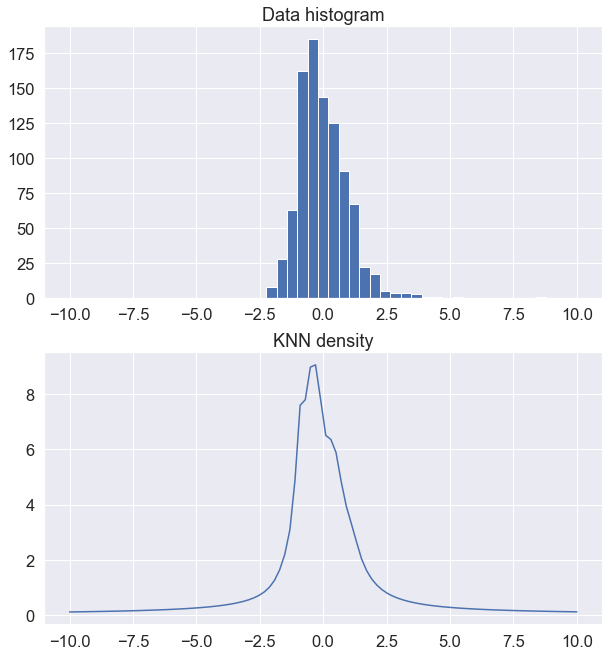

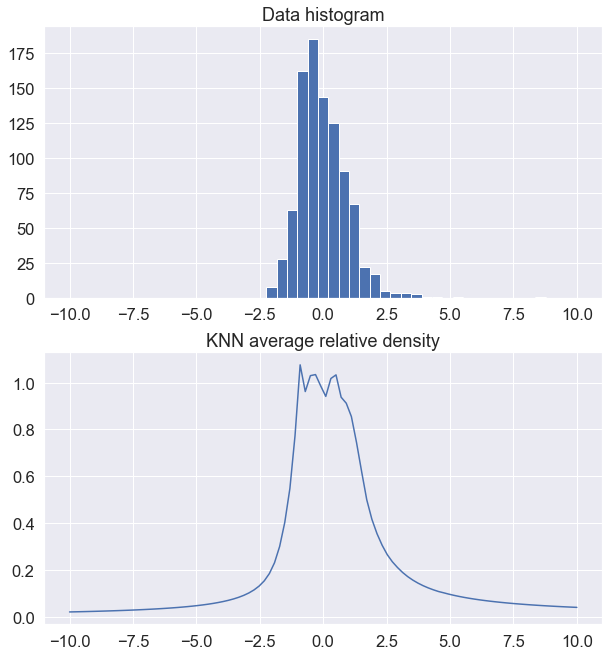

In [115]:
# exercise 11.2.3
import numpy as np
from matplotlib.pyplot import figure, subplot, plot, hist, title, show
from sklearn.neighbors import NearestNeighbors


# # Draw samples from mixture of gaussians (as in exercise 11.1.1)
# N = 1000; M = 1
x = np.linspace(-10, 10, 50)
# X = np.empty((N,M))
# m = np.array([1, 3, 6]); s = np.array([1, .5, 2])
# c_sizes = np.random.multinomial(N, [1./3, 1./3, 1./3])
# for c_id, c_size in enumerate(c_sizes):
#     X[c_sizes.cumsum()[c_id]-c_sizes[c_id]:c_sizes.cumsum()[c_id],:] = np.random.normal(m[c_id], np.sqrt(s[c_id]), (c_size,M))

# Number of neighbors
K = 200

# x-values to evaluate the KNN
xe = np.linspace(-10, 10, 100)

# Find the k nearest neighbors
knn = NearestNeighbors(n_neighbors=K).fit(X)
D, i = knn.kneighbors(np.matrix(xe).T)

# Compute the density
#D, i = knclassifier.kneighbors(np.matrix(xe).T)
knn_density = 1./(D.sum(axis=1)/K)

# Compute the average relative density
DX, iX = knn.kneighbors(X)
knn_densityX = 1./(DX[:,1:].sum(axis=1)/K)
knn_avg_rel_density = knn_density/(knn_densityX[i[:,1:]].sum(axis=1)/K)


# Plot KNN density
figure(figsize=(10,11))
subplot(2,1,1)
hist(X,x)
title('Data histogram')
subplot(2,1,2)
plot(xe, knn_density)
title('KNN density')
plt.savefig('../report/images/knn_density.png')

# Plot KNN average relative density
figure(figsize=(10,11))
subplot(2,1,1)
hist(X,x)
title('Data histogram')
subplot(2,1,2)
plot(xe, knn_avg_rel_density)
title('KNN average relative density')
plt.savefig('../report/images/knn_ard.png')

show()

In [117]:
from sklearn.neighbors import KernelDensity
from numpy import exp, asarray

kde = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(X)

#  x = np.linspace(-10, 10, 50)

values = np.linspace(-4, 6, 50)
values = values.reshape((len(values), 1))
probabilities = kde.score_samples(values)

probabilities = exp(probabilities)

# print(values)

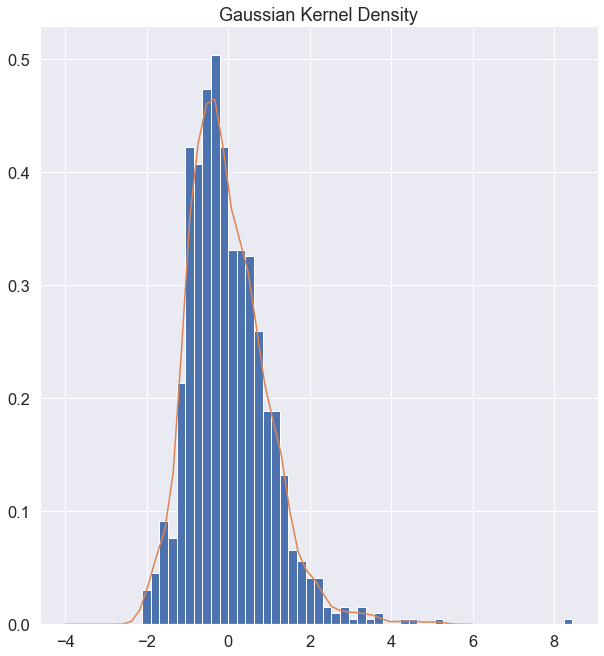

In [119]:
figure(figsize=(10,11))
plt.hist(X, bins=50, density=True)
plt.plot(values[:], probabilities)
plt.title('Gaussian Kernel Density')
plt.savefig('../report/images/knn_gkd.png')
plt.show()

In [319]:
## anomaly detection

values = np.linspace(-5, 5, 932).reshape(-1,1)

densities = kde.score_samples(values)
density_threshold = np.percentile(densities, 4)
anomalies = X[densities < density_threshold]

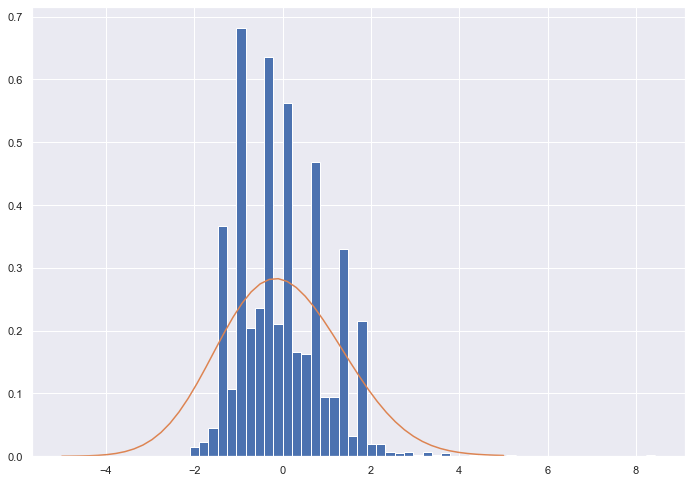

In [330]:
# example of kernel density estimation for a bimodal data sample
from matplotlib import pyplot
from numpy.random import normal
from numpy import hstack
from numpy import asarray
from numpy import exp
from sklearn.neighbors import KernelDensity
# generate a sample
sample1 = df_hrv_scaled['HRV'].values.reshape(-1,1)
sample2 = df_hrv_scaled['Day of week'].values.reshape(-1,1)
# sample = hstack((sample1, sample2)).reshape(-1,1)
sample = df_hrv_scaled[['HRV', 'Day of week']].values.reshape(-1,1)
# fit density
model = KernelDensity(bandwidth=1, kernel='gaussian')
# sample = sample.reshape((len(sample), 1))
model.fit(sample)
# sample probabilities for a range of outcomes
values = np.linspace(-5, 5, 50)
values = values.reshape((len(values), 1))
probabilities = model.score_samples(values)
probabilities = exp(probabilities)
# plot the histogram and pdf
pyplot.hist(sample, bins=50, density=True)
pyplot.plot(values[:], probabilities)
pyplot.show()

In [128]:
cat_columns = ['Hour of Day', 'Day of Week', 'HRV (SDNN)']
df_processed = pd.get_dummies(hrv_copy, prefix_sep="__",columns=cat_columns)
del df_processed['Is at Work (binary)']
del df_processed['Is Above Mean Value']
del df_processed['Is Morning']

df_processed.describe()

# print(tabulate(df_processed.head(), tablefmt="pipe", headers="keys"))

# hrv_copy.head()

,Hour of Day__0,Hour of Day__1,Hour of Day__2,Hour of Day__3,Hour of Day__5,Hour of Day__6,Hour of Day__7,Hour of Day__8,Hour of Day__9,Hour of Day__10,...,HRV (SDNN)__91.2839,HRV (SDNN)__92.0808,HRV (SDNN)__92.2314,HRV (SDNN)__96.6417,HRV (SDNN)__98.3279,HRV (SDNN)__98.5152,HRV (SDNN)__107.476,HRV (SDNN)__113.241,HRV (SDNN)__121.34100000000001,HRV (SDNN)__173.52599999999998
count,932.000000,932.000000,932.000000,932.000000,932.000000,932.000000,932.000000,932.000000,932.000000,932.000000,...,932.000000,932.000000,932.000000,932.000000,932.000000,932.000000,932.000000,932.000000,932.000000,932.000000
mean,0.013948,0.017167,0.008584,0.001073,0.006438,0.007511,0.020386,0.045064,0.110515,0.080472,...,0.001073,0.001073,0.001073,0.001073,0.001073,0.001073,0.001073,0.001073,0.001073,0.001073
std,0.117340,0.129965,0.092299,0.032756,0.080020,0.086385,0.141393,0.207557,0.313699,0.272169,...,0.032756,0.032756,0.032756,0.032756,0.032756,0.032756,0.032756,0.032756,0.032756,0.032756
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [125]:
df_processed.reset_index()

records = []
N, M = df_processed.shape

def print_me(j):
    ## Only "1"'s matter
    if(row[j] == 1):
        return df_processed.columns[j]
    return None

for (index, row) in df_processed.iterrows():
    records.append([
        print_me(j)
        for j in range(0, M-1)])

# Remove "None"'s
records_cleaned = [(list(filter(None,x))) for x in records]

print(records_cleaned)

[['Hour of Day__9', 'Day of Week__2', 'HRV (SDNN)__32.397'], ['Hour of Day__9', 'Day of Week__2', 'HRV (SDNN)__45.1124'], ['Hour of Day__14', 'Day of Week__2', 'HRV (SDNN)__27.3781'], ['Hour of Day__21', 'Day of Week__2', 'HRV (SDNN)__41.4216'], ['Hour of Day__9', 'Day of Week__4', 'HRV (SDNN)__41.0526'], ['Hour of Day__9', 'Day of Week__4', 'HRV (SDNN)__43.2457'], ['Hour of Day__20', 'Day of Week__4', 'HRV (SDNN)__28.3643'], ['Hour of Day__8', 'Day of Week__5', 'HRV (SDNN)__53.743'], ['Hour of Day__11', 'Day of Week__6', 'HRV (SDNN)__38.5957'], ['Hour of Day__14', 'Day of Week__6', 'HRV (SDNN)__43.1893'], ['Hour of Day__16', 'Day of Week__6', 'HRV (SDNN)__31.4732'], ['Hour of Day__17', 'Day of Week__1', 'HRV (SDNN)__28.6433'], ['Hour of Day__10', 'Day of Week__2', 'HRV (SDNN)__26.1331'], ['Hour of Day__14', 'Day of Week__2', 'HRV (SDNN)__41.9345'], ['Hour of Day__17', 'Day of Week__2', 'HRV (SDNN)__15.9217'], ['Hour of Day__8', 'Day of Week__3', 'HRV (SDNN)__56.0'], ['Hour of Day__14'

In [154]:
from apyori import apriori

association_rules = apriori(records_cleaned, min_support=0.005, min_confidence=0.020, min_lift=2, min_length=1)
association_results = list(association_rules) 

associations = []
confidence = []



for item in association_results:
    print(item[0])
    associations.append(item[0])
    print(item[1])
    confidence.append(item[1])
    print(item[2])

df_associations = pd.DataFrame()

df_associations['associations'] = associations
df_associations['confidence'] = confidence

print(tabulate(df_associations.head(), tablefmt="pipe", headers="keys"))

frozenset({'Day of Week__6', 'Hour of Day__11'})
0.009656652360515022
[OrderedStatistic(items_base=frozenset({'Day of Week__6'}), items_add=frozenset({'Hour of Day__11'}), confidence=0.08653846153846154, lift=2.601736972704715), OrderedStatistic(items_base=frozenset({'Hour of Day__11'}), items_add=frozenset({'Day of Week__6'}), confidence=0.2903225806451613, lift=2.601736972704715)]
frozenset({'Day of Week__6', 'Hour of Day__23'})
0.0075107296137339056
[OrderedStatistic(items_base=frozenset({'Day of Week__6'}), items_add=frozenset({'Hour of Day__23'}), confidence=0.0673076923076923, lift=2.163129973474801), OrderedStatistic(items_base=frozenset({'Hour of Day__23'}), items_add=frozenset({'Day of Week__6'}), confidence=0.24137931034482757, lift=2.163129973474801)]
frozenset({'Hour of Day__17', 'Day of Week__7'})
0.018240343347639486
[OrderedStatistic(items_base=frozenset({'Day of Week__7'}), items_add=frozenset({'Hour of Day__17'}), confidence=0.22972972972972974, lift=2.405709079866383)